In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time

from IPython import display

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_images.shape

(60000, 28, 28, 1)

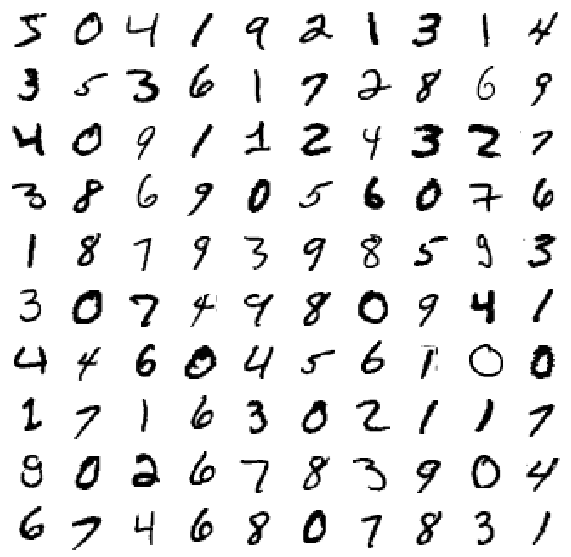

In [3]:
plt.rcParams["figure.figsize"] = (10,10)
for i in range(100):
    plt.subplot(10, 10, 1 + i)
    plt.axis('off')
    plt.imshow(train_images[i][:,:,0], cmap='gray_r')
plt.show()

In [4]:
def make_generator_model(latent_dim=100, num_classes=10):
    in_label = layers.Input(shape=(1,))
    li = layers.Embedding(num_classes, 50)(in_label)
    n_nodes = 7 * 7
    li = layers.Dense(n_nodes)(li)
    li = layers.Reshape((7, 7, 1))(li)
    
    in_lat = layers.Input(shape=(latent_dim,))
    n_nodes = 128 * 7 * 7
    gen = layers.Dense(n_nodes)(in_lat)
    gen = layers.LeakyReLU(alpha=0.2)(gen)
    gen = layers.Reshape((7, 7, 128))(gen)
    merge = layers.Concatenate()([gen, li])

    gen = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(merge)
#     gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU()(gen)

    gen = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(gen)
#     gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU()(gen)
    

    out_layer = layers.Conv2D(1, (7, 7), padding='same', activation='tanh')(gen)
    
    model = tf.keras.Model((in_label,in_lat),out_layer)
    return model
    
    

In [5]:
def make_discriminator_model(num_classes=10,in_shape=(28,28,1)):

    input1 = layers.Input(shape=(1,))
    li = layers.Embedding(num_classes, 50)(input1)
    n_nodes = in_shape[0] * in_shape[1]
    li = layers.Dense(n_nodes)(li)
    li = layers.Reshape((in_shape[0], in_shape[1], 1))(li)
    
    input2 = tf.keras.Input(shape=in_shape)
    
    merge = layers.Concatenate()([li, input2])
    dis = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(merge)
    dis = layers.LeakyReLU()(dis)
    dis = layers.Dropout(0.3)(dis)

    dis = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(dis)
    dis = layers.LeakyReLU()(dis)
    dis = layers.Dropout(0.3)(dis)

    dis = layers.Flatten()(dis)
    outputs = layers.Dense(1, activation='sigmoid')(dis)

    return tf.keras.Model(inputs=(input1, input2), outputs=outputs)

In [6]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = (real_loss + fake_loss) * 0.5
    return real_loss, fake_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Make generator and discriminator model

In [7]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [8]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1, 784)       39984       embedding_1[0][0]                
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 28, 28, 1)    0           dense_2[0][0]                    
____________________________________________________________________________________________

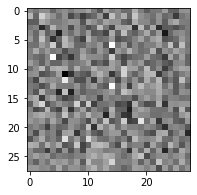

In [9]:
plt.rcParams["figure.figsize"] = (3,3)
noise = tf.random.normal([2, 100])
generated_image = generator((train_labels[:2].astype(np.float32),noise))
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [10]:
discriminator((train_labels[:2].astype(np.float32),generated_image))

<tf.Tensor: id=660, shape=(2, 1), dtype=float32, numpy=
array([[0.49938926],
       [0.5000281 ]], dtype=float32)>

### Training parameters

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [12]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
BUFFER_SIZE = 60000
BATCH_SIZE = 128

#### Testing examples to generate images

In [13]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])
labels_seed = tf.random.uniform( 
    shape=[num_examples_to_generate,],
    minval=0,
    maxval=9,
    dtype=tf.dtypes.int32
)
print(seed.shape, labels_seed.shape)

(16, 100) (16,)


### Train step and train loop

In [14]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    fake_labels = tf.random.uniform([BATCH_SIZE,], minval=0, maxval=9, dtype=tf.dtypes.int32)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        generated_images = generator((fake_labels, noise), training=True)

        real_output = discriminator((labels, images), training=True)
        fake_output = discriminator((fake_labels, generated_images), training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss_1, disc_loss_2 = discriminator_loss(real_output, fake_output)
    tf.print(gen_loss, disc_loss_1, disc_loss_2)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator_1 = disc_tape.gradient(disc_loss_1, discriminator.trainable_variables)
    gradients_of_discriminator_2 = disc_tape.gradient(disc_loss_2, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator_1, discriminator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator_2, discriminator.trainable_variables))

In [15]:
def train(train_images, train_labels, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch,labels_batch in dataset_generator(train_images,train_labels,BATCH_SIZE):      
            train_step(image_batch, labels_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 (labels_seed, seed))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        

        # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                               epochs,
                               (labels_seed, seed))
        
def generate_and_save_images(model, epoch, test_input):
    print(test_input)
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, 0] + 1)  / 2, cmap='gray_r')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    
def dataset_generator(images, labels, batch_size):
    for i in range(images.shape[0]//batch_size):
        idx = np.random.randint(0, images.shape[0], batch_size)
    
        imgs, labls = images[idx], labels[idx]
        yield imgs, labls

### Run training

In [16]:

%%time
train(train_images, train_labels, EPOCHS)

RuntimeError: in converted code:

    <ipython-input-14-7cc1b7554538>:19 train_step  *
        gradients_of_discriminator_2 = disc_tape.gradient(disc_loss_2, discriminator.trainable_variables)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/eager/backprop.py:965 gradient
        raise RuntimeError("GradientTape.gradient can only be called once on "

    RuntimeError: GradientTape.gradient can only be called once on non-persistent tapes.
